# `OpenMC` example

### Importing the Python modules necessary to run OpenMC

In [1]:
import os
os.environ['OPENMC_CROSS_SECTIONS'] = '/home/nacho/openmc/data/endfb-vii.1-hdf5/cross_sections.xml'
import numpy as np
import matplotlib.pyplot as plt
import openmc
import pandas as pd
from matplotlib.colors import LogNorm
from PIL import Image   
from uncertainties import ufloat, unumpy
import h5py


### Materials

Materials are defined by calling [`openmc.Material()`](https://docs.openmc.org/en/stable/pythonapi/generated/openmc.Material.html#openmc-material) to create the material object and then using the `mat.add_nuclide()` or `mat.add_element()` methods to build the composition.

The first parameter is the nuclide or element, the second one is the fraction, and the third one is the units.

Compositions can be expressed in percentage of atoms (`ao`), percentage of mass (`wo`) or atom density (`at/cm3`).

To se the total density of the material, the module `.set_density()` should be called. The possible units are `g/cm3`, `atom/b-cm`, `kg/m3` or `sum` (asumes that the concentrations of the nuclides/elements are in `atom/b-cm`)

It is possible to ad an $S(\alpha,\beta)$ library, which will replace the cross sections for low energies.



In [111]:
deu = openmc.Material(1, 'deuterio', 293.5943174)
deu.add_nuclide('H2', 1, 'ao')
deu.set_density('atom/cm3', (985796446e13/0.0165)*0.01)
print(deu)



hid = openmc.Material(2, 'hidrogeno', 293.5943174)
hid.add_nuclide('H1', 1, 'ao')
hid.set_density('g/cm3', 0.01)
print(hid)

Material
	ID             =	1
	Name           =	deuterio
	Temperature    =	293.5943174
	Density        =	5.974523915151516e+21 [atom/cm3]
	Volume         =	None [cm^3]
	S(a,b) Tables  
	Nuclides       
	H2             =	1            [ao]

Material
	ID             =	2
	Name           =	hidrogeno
	Temperature    =	293.5943174
	Density        =	0.01 [g/cm3]
	Volume         =	None [cm^3]
	S(a,b) Tables  
	Nuclides       
	H1             =	1            [ao]



/home/nacho/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/home/nacho/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)


### Geometry

The geometry is defined using [Constructive Solid Geometry](https://en.wikipedia.org/wiki/Constructive_solid_geometry) (CSG). First, a set of simple surfaces are defined. Mathematically, the surfaces are defined as $f(x,y,z)=0$, giving the parameters of the function. Each surface defines two regions, one where $f(x,y,z)>0$, and one where $f(x,y,z)<0$. By combining the regions using the union (`|`), intersection (`&`) and complement (`~`) we can define regions of the space.

The basic unit of the geometry in OpenMC is the *Cell*, which is a region of space with something that fills it.

The surfaces with `vacuum` boundary conditions means that the particles that reach this surface will be eliminated. By default, the `transmission` boundary is setted. Other options are `reflective`, `periodic` and `white`.

A collection of cells is a *Universe*, and it can be used to fill other cells for nested geometries.

The surface units are in `cm`

#### Surfaces

In [112]:
L=20
xtop=openmc.XPlane(x0=L/2, boundary_type='vacuum', surface_id=1)
xbot=openmc.XPlane(x0=-L/2, boundary_type='vacuum', surface_id=2)
ytop=openmc.YPlane(y0=L/2, boundary_type='vacuum', surface_id=3)
ybot=openmc.YPlane(y0=-L/2, boundary_type='vacuum', surface_id=4)
ztop=openmc.ZPlane(z0=L/2, boundary_type='vacuum', surface_id=5)
zbot=openmc.ZPlane(z0=-L/2, boundary_type='vacuum', surface_id=6)



/home/nacho/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=1.
  warn(msg, IDWarning)
/home/nacho/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=2.
  warn(msg, IDWarning)
/home/nacho/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=3.
  warn(msg, IDWarning)
/home/nacho/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=4.
  warn(msg, IDWarning)
/home/nacho/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=5.
  warn(msg, IDWarning)
/home/nacho/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=6.
  warn(msg, IDWarning)


#### Regions

In [113]:
region=-xtop & +xbot & -ytop & +ybot & -ztop & +zbot


#### Cells

In [114]:
cell=openmc.Cell(region=region,fill=deu,cell_id=1)


/home/nacho/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)


#### Universe(s)

In [115]:
univ01 =openmc.Universe(cells= [cell], universe_id=1)

/home/nacho/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another UniverseBase instance already exists with id=1.
  warn(msg, IDWarning)


The `Universe()` class has a `plot()` method to show the geometry. L We can plot the geometry using different colors for the different materials or for the different cells

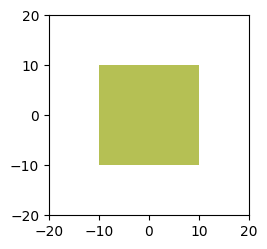

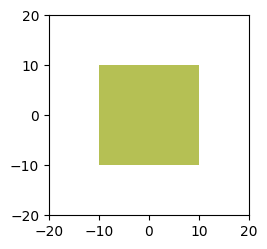

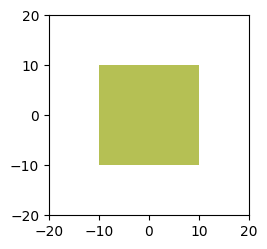

In [116]:
univ01.plot(width=(40, 40),  basis='xy', color_by='material')
univ01.plot(width=(40, 40), basis='xz', color_by='material')
univ01.plot(width=(40, 40), basis='yz', color_by='material')

### Plots (optional)

It is possible to call a `openmc.plot` run command later. In this case, the `Plot` module should be called and defined


In [117]:
plots = openmc.Plots()

plot_xz = openmc.Plot()
plot_xz.id = 1
plot_xz.basis = 'xz'
plot_xz.origin = (0,0,0.0)
plot_xz.width = (40,40)
plot_xz.pixels = (100, 100)
plot_xz.color_by='material'
plots.append(plot_xz)

/home/nacho/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another PlotBase instance already exists with id=1.
  warn(msg, IDWarning)


### mesh

In [118]:
mesh = openmc.RegularMesh(mesh_id=1)
mesh.lower_left=(-L/2,-L/2,-L/2)
mesh.upper_right=(L/2,L/2,L/2)
mesh.dimension = [1, 1, 1]


/home/nacho/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)


### Tallies (optional)

With the `Tallies` module, we can define what we want to compute from the simulations. These tallies count a specific *Score* discrimined by different *Filters*.

#### Filters

In [119]:
tallies = openmc.Tallies()
current_nomatter = openmc.Tally(name='Fdet')
current_nomatter.scores = ['current']
current_nomatter.filters = [openmc.EnergyFilter([90.0,100.0]), openmc.SurfaceFilter(ybot)]
current_nomatter.estimator = 'analog'
tallies.append(current_nomatter)

currentmesh = openmc.Tally(name='Fdetmesh')
currentmesh.scores = ['current']
currentmesh.filters = [openmc.EnergyFilter([90.0,100.0]), openmc.MeshSurfaceFilter(mesh)]
#currentmesh.estimator = 'analog'
tallies.append(currentmesh)


### Settings

We will now define the settings for the simulation:


* What type of simulation we want to run (fixed source or multiplication eigenvalue)
* How many particles we want to simulate
* The distribution of the source in space, angle and energy.

Also, we can specify if we want to create a file with all the particles that cross a certain surface

#### Specify the PATH for the nuclear data and the executable

In [120]:
openmc_exe= '/home/nacho/openmc/CARLITOS/build/bin/openmc'
openmc_data="/home/nacho/openmc/data/endfb-vii.1-hdf5/cross_sections.xml"

In [121]:
geom = openmc.Geometry(univ01)
geom.export_to_xml()

mats = openmc.Materials(geom.get_all_materials().values())
mats.cross_sections = openmc_data
mats.export_to_xml()

plots.export_to_xml()

tallies.export_to_xml()


/home/nacho/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=16.
  warn(msg, IDWarning)


#### Plot the geometry

In [122]:
openmc.plot_geometry(openmc_exec=openmc_exe)

CORRIOOOOO
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 ##########

### SETINGS

The input for OpenMC is described by, at least, 3 XML files:

*   `materials.xml`: describes the materials of the system.
*   `geometry.xml`: describes the geometry of the system.
*   `settings.xml`: describes the running parameters of the system.
*   `plots.xml`: describes the plot running parameters.
*   `tallies.xml`: describes the tallies that will be computing during the simulation.

The OpenMC Python API allows us to create those files and also to postprocess the output.

We should call, for every macro-variable, the `.export_to_xml()` function

In [123]:
settings = openmc.Settings()
settings.run_mode='fixed source'
settings.particles = int(1e6)
settings.batches = 1
settings.inactive = 0
settings.survival_biasing=True
settings.photon_transport=False


### CHAR-0

In [124]:
source = openmc.Source()
source.space = openmc.stats.Point(xyz=[0, 0, 0])
source.angle = openmc.stats.Isotropic()


energies = np.linspace(589.55, 99500.45, 100)

for i in energies:
    source.energy = openmc.stats.Discrete([i], [1.0])
    settings.source = source
    settings.export_to_xml()
    os.system("rm summary.h5")
    openmc.run(openmc_exec=openmc_exe)
    string1 = 'statepoint.'+str(settings.batches)+'.h5'
    string2 = 'statepoint.'+str(i)+'.h5'
    mv_cmd = 'mv ' + string1 + ' ' + string2 
    os.system(mv_cmd)


CORRIOOOOO
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 ##########

### Reading the tallies

The run creates a binary file called *Statepoint*. We will load this file, extract the tallies and plot them.

/home/nacho/.local/lib/python3.10/site-packages/openmc/tallies.py:279: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -
/home/nacho/.local/lib/python3.10/site-packages/openmc/tallies.py:279: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -
/home/nacho/.local/lib/python3.10/site-packages/openmc/tallies.py:279: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -
/home/nacho/.local/lib/python3.10/site-packages/openmc/tallies.py:279: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -
/home/nacho/.local/lib/python3.10/site-packages/openmc/tallies.py:279: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -
/home/nacho/.local/lib/python3.10/site-packages/openmc/tallies.py:279: RuntimeWa

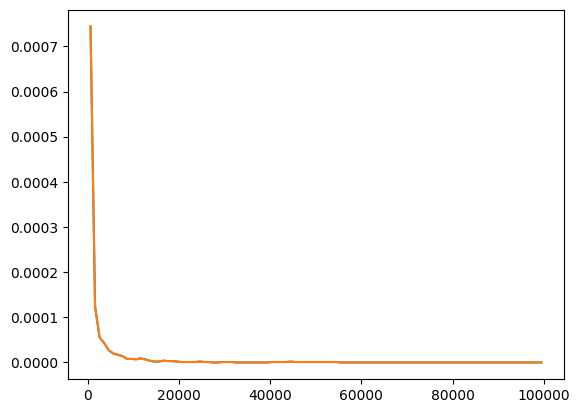

In [125]:
sp = {}
talli = {}
tallimesh = {}
fadj = np.zeros(len(energies), dtype=float)
fadjerr = np.zeros(len(energies), dtype=float)
fadjmesh = np.zeros(len(energies), dtype=float)

for i in range(len(energies)):
    string3 = 'statepoint.'+str(energies[i])+'.h5'
    sp[i]=openmc.StatePoint(string3)
    talli[i]=sp[i].get_tally(name='Fdet')
    fadj[i]=(-1.0)*float(talli[i].mean.flatten())
    fadjerr[i]=float(talli[i].std_dev.flatten())

    tallimesh[i]=sp[i].get_tally(name='Fdetmesh').get_pandas_dataframe()
    if len(tallimesh[i].columns)>9:
        tallimesh[i].columns = ['Emin', 'Emax', 'x', 'y', 'z', 'surf', 'nuclide', 'score', 'mean', 'std_dev']    
    else:
        tallimesh[i].columns = ['Emin', 'Emax', 'x', 'y', 'z', 'surf', 'nuclide', 'score', 'mean']
    fadjmesh[i]=tallimesh[i][tallimesh[i]['surf']=='y-min out']['mean'].values[0]

plt.plot(energies, fadj)
plt.plot(energies, fadjmesh)
np.savetxt('results.txt', np.column_stack((energies, fadj)), delimiter='\t')

